In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load library

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from PIL.ImageOps import exif_transpose
from torchinfo import summary
import cv2
import tensorflow
from tqdm import tqdm
import torchmetrics
import albumentations as A

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset

## Load dataset

In [ ]:
working_dir = "/kaggle/working/"
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:37<00:00, 21151352.97it/s]


Extracting /kaggle/working/OxfordPets/train/oxford-iiit-pet/images.tar.gz to /kaggle/working/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 9880851.12it/s] 


Extracting /kaggle/working/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:37<00:00, 21150430.78it/s]


Extracting /kaggle/working/OxfordPets/test/oxford-iiit-pet/images.tar.gz to /kaggle/working/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11385072.24it/s]


Extracting /kaggle/working/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/OxfordPets/test/oxford-iiit-pet


In [ ]:
txt_path = "/kaggle/working/OxfordPets/train/oxford-iiit-pet/annotations/trainval.txt"
mask_path = "/kaggle/working/OxfordPets/train/oxford-iiit-pet/annotations/trimaps/american_bulldog_146.png"
img_path = "/kaggle/working/OxfordPets/train/oxford-iiit-pet/images/american_bulldog_146.jpg"

In [ ]:
root_dir = "/kaggle/working/OxfordPets"
types = "train"
txt_file = "/kaggle/working/OxfordPets/train/oxford-iiit-pet/annotations/trainval.txt"


In [ ]:
import random
li = []
with open(txt_file) as f:
    for line in f:
        li.append(line.split(" ")[0])
idx = random.randint(0,100)
print(idx)
cv_path = os.path.join(root_dir, types, "oxford-iiit-pet/images", "{}.jpg".format(li[idx]))
cv_maskpath = os.path.join(root_dir, types, "oxford-iiit-pet/annotations/trimaps", "{}.png".format(li[idx]))
cv_path

59


'/kaggle/working/OxfordPets/train/oxford-iiit-pet/images/american_bulldog_109.jpg'

shape: cv_mask (500, 335)
type: cv_mask <class 'numpy.ndarray'>


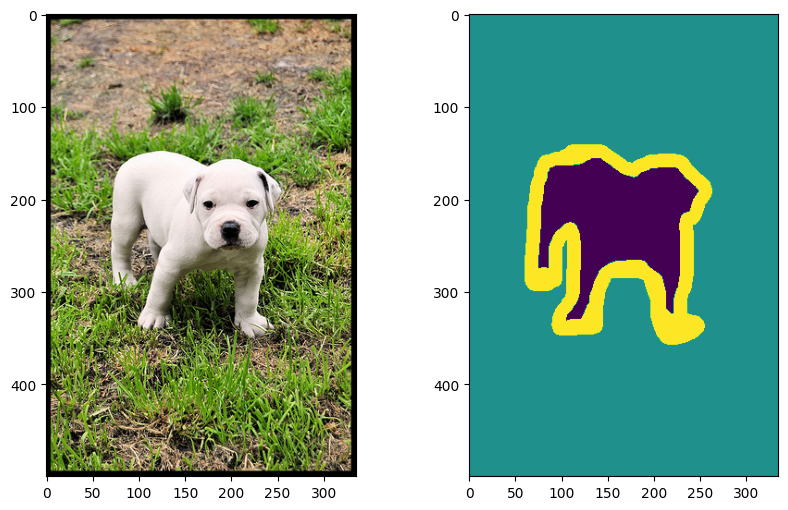

In [ ]:
cv_image = cv2.imread(cv_path)
cv_im = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
cv_mask = cv2.imread(cv_maskpath,cv2.IMREAD_GRAYSCALE)


fig= plt.figure(figsize = (10, 6))
fig.add_subplot(1,2,1)
plt.imshow(cv_im)

fig.add_subplot(1,2,2)
plt.imshow(cv_mask)

print("shape: cv_mask",cv_mask.shape)
print("type: cv_mask", type(cv_mask))

## Create DataLoader

In [ ]:
class SegDatasets(torch.utils.data.Dataset):
    def __init__(self, root_dir, txt_file, size = 384, types = "train"):
        super().__init__()
        self.data_root = root_dir
        self.txt_file = txt_file
        self.type = types
        self.image_path = []
        self.size = size
        with open(self.txt_file) as f:
            for line in f:
                self.image_path.append(line.split(" ")[0])


        self.transform_train = A.Compose([
            A.Resize(height = self.size, width = self.size, interpolation = cv2.INTER_LINEAR),
            A.Normalize(),
            A.HorizontalFlip(p = 0.6),
            A.Blur(),
            A.RandomBrightnessContrast(p = 0.6),
            A.CoarseDropout(p = 0.6, max_holes=18, max_height=24, max_width=24, min_holes=12, min_height=12, min_width=12, fill_value=0)
        ])


    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):

        img_path = os.path.join(self.data_root, self.type, "oxford-iiit-pet/images", "{}.jpg".format(self.image_path[idx]))
        mask_path = os.path.join(self.data_root, self.type, "oxford-iiit-pet/annotations/trimaps", "{}.png".format(self.image_path[idx]))

        img = cv2.imread(img_path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image_mask -= 1

        transformed = self.transform_train(image = image, mask = image_mask)
        inputs_image = transformed["image"]
        inputs_mask = transformed["mask"]

        # array -> tensor
        img_tensor = torch.from_numpy(inputs_image).permute(2,0,1).to(torch.float32)
        #mask_tensor = torch.from_numpy(inputs_mask).unsqueeze(0) # unsqueeze(0): (128,128) -> (1,128,128)

        return img_tensor, inputs_mask




In [ ]:
class UnNormalize(object):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [ ]:
unorm = UnNormalize()

In [ ]:
data_train = SegDatasets(root_dir, size = 128, types = "train", txt_file = "/kaggle/working/OxfordPets/train/oxford-iiit-pet/annotations/trainval.txt")
data_test = SegDatasets(root_dir, size = 128, types = "test", txt_file = "/kaggle/working/OxfordPets/test/oxford-iiit-pet/annotations/test.txt")

In [ ]:
dataloader_train = torch.utils.data.DataLoader(data_train,
                                        batch_size = 16,
                                        shuffle = True)

In [ ]:
(inputs, targets) = next(iter(dataloader_train))

6


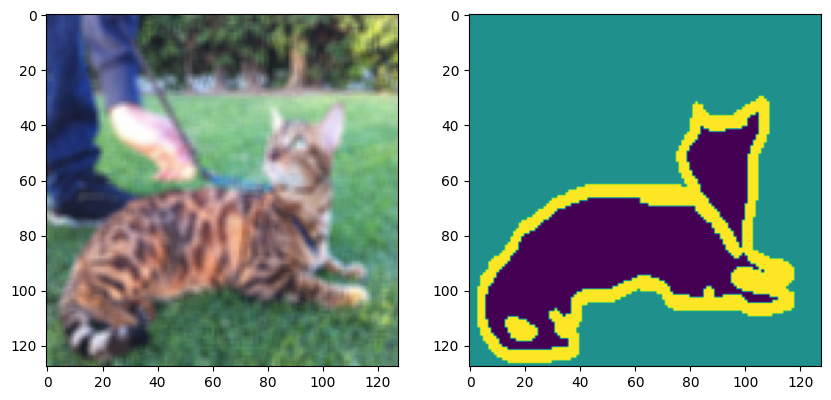

In [ ]:
id = random.randint(0,15)
print(id)

fig= plt.figure(figsize = (10, 6))
fig.add_subplot(1,2,1)
plt.imshow(unorm(inputs[id]).permute(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(targets[id]) #transforms.ToPILImage()(targets[id]))


# Model

## Unet

In [ ]:
#Unet
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding):
        super().__init__()
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, padding = padding)
        self.act1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(out_channels)

        self.second = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, padding = padding)
        self.act2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(out_channels)


    def forward(self, x: torch.Tensor):
        x = self.first(x)
        x = self.act1(x)
        x = self.norm1(x)
        x = self.second(x)
        x = self.act2(x)
        x = self.norm2(x)
        return x

class Downsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size : int, padding):
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            DoubleConv(in_channels, out_channels, kernel_size = kernel_size, padding = padding),
            DoubleConv(out_channels, out_channels, kernel_size = kernel_size, padding = padding),
        )
    def forward(self, x: torch.Tensor):
        return self.maxpool_conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size : int, padding):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2)

        self.conv = nn.Sequential(
            DoubleConv(in_channels, out_channels, kernel_size = kernel_size, padding = padding),
            DoubleConv(out_channels, out_channels, kernel_size = kernel_size, padding = padding),
        )

    def forward(self, x: torch.Tensor, skip_x: torch.Tensor):
        x = self.up(x)
        x = torch.cat([x, skip_x], dim = 1)
        x = self.conv(x)
        return x


class Unet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.inc = DoubleConv(in_channels, 64, 9, padding = "same")
        self.down1 = Downsample(64, 128, 5, padding = "same")
        self.down2 = Downsample(128, 256, 5, padding = "same")
        self.down3 = Downsample(256, 512, 3, padding = "same")

        self.middle = Downsample(512, 1024, 3, padding = "same")

        self.up1 = Upsample(1024, 512, 3, padding = "same")
        self.up2 = Upsample(512, 256, 3, padding = "same")
        self.up3 = Upsample(256, 128, 3, padding = "same")
        self.up4 = Upsample(128, 64, 3, padding = "same")
        self.out = nn.Conv2d(64, out_channels, 1, padding = "same")

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x5 = self.middle(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.out(x)


        return output



In [ ]:
model = Unet(3,3)
x = torch.rand(16,3,128,128)
print("input shape", x.shape)
y = model(x)
print("output shape", y.shape)

input shape torch.Size([16, 3, 128, 128])
output shape torch.Size([16, 3, 128, 128])


## tools


In [ ]:
# target (16,1,128,128)
#pred (16,128,128)
def accuracy_fn(preds, targets):
    preds_squeeze = torch.argmax(preds, dim = 1).float()# (16,3,128,128) -> (13,1,128,128)
    targets = targets.long()

    preds_flat = preds_squeeze.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc / targets_flat.shape[0]

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import wandb
wandb.init(project = "Segmentations Dog-Cat")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Train!!!

In [ ]:
# Train!
torch.cuda.empty_cache()
import gc
gc.collect()

learning_rate = 0.001
num_epochs = 70
n_classes = 3

model = Unet(3,n_classes)
if torch.cuda.is_available():
    model.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

dice_fn = torchmetrics.Dice(num_classes = n_classes, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes = n_classes, task = "multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()


for epoch in range(num_epochs):
    model.train()
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader_train), start = 1):
        n = inputs.shape[0]

        x = inputs.to(device).float()
        y = targets.to(device).float().long() # (16,128,128))

        y_h = model(x) # (16, 3, 128, 128)
        #
        loss = criterion(y_h, y)   # preds [B, num_class, H, W], y_true [B, H, W]

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        with torch.no_grad():
            #metric
            #y_h = torch.argmax(y_h, dim = 1).squeeze() # ypred.shape (B,3,H,W) -> (B,1,H,W) -> (B,H,W)
            dice_score = dice_fn(y_h, y)
            iou_score = iou_fn(y_h, y)
            accuracy = accuracy_fn(y_h, y)

            #update
            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    wandb.log({"Loss per Epoch": train_loss_meter.avg,
               "Accuracy per Epoch": acc_meter.avg,
               "IoU Score": iou_meter.avg,
               "Dice Score": dice_meter.avg})
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train_loss: {train_loss_meter.avg:.4f}, accuracy: {acc_meter.avg:.4f}, IoU: {iou_meter.avg:.4f}, dice: {dice_meter.avg:.4f})")

100%|██████████| 230/230 [01:18<00:00,  2.92it/s]


Epoch [1/70], Train_loss: 0.8190, accuracy: 0.6592, IoU: 0.3621, dice: 0.4783)


100%|██████████| 230/230 [01:16<00:00,  3.00it/s]


Epoch [2/70], Train_loss: 0.7111, accuracy: 0.7083, IoU: 0.3919, dice: 0.5024)


100%|██████████| 230/230 [01:16<00:00,  3.00it/s]


Epoch [3/70], Train_loss: 0.6974, accuracy: 0.7149, IoU: 0.4014, dice: 0.5140)


100%|██████████| 230/230 [01:16<00:00,  3.01it/s]


Epoch [4/70], Train_loss: 0.6915, accuracy: 0.7167, IoU: 0.4025, dice: 0.5142)


100%|██████████| 230/230 [01:16<00:00,  3.01it/s]


Epoch [5/70], Train_loss: 0.6762, accuracy: 0.7254, IoU: 0.4166, dice: 0.5315)


100%|██████████| 230/230 [01:16<00:00,  3.01it/s]


Epoch [6/70], Train_loss: 0.6691, accuracy: 0.7294, IoU: 0.4226, dice: 0.5384)


100%|██████████| 230/230 [01:16<00:00,  3.01it/s]


Epoch [7/70], Train_loss: 0.6491, accuracy: 0.7397, IoU: 0.4378, dice: 0.5555)


100%|██████████| 230/230 [01:16<00:00,  3.01it/s]


Epoch [8/70], Train_loss: 0.6475, accuracy: 0.7407, IoU: 0.4394, dice: 0.5577)


  2%|▏         | 4/230 [00:01<01:14,  3.05it/s]

# Inference


In [ ]:
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size = 16, shuffle = True)


In [ ]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()

with torch.no_grad():
    for batch, (inputs,targets) in enumerate(tqdm(dataloader_test), start = 1):
        n = inputs.shape[0]

        x = inputs.to(device)
        y = targets.to(device).long()

        y_h = model(x)
        dice_score = dice_fn(y_h, y)
        iou_score = iou_fn(y_h, y)
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IOU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

In [ ]:
model.eval()
id = random.randint(0, 100)
with torch.no_grad():
    inputs, targets = data_test[id]
    print(f"inputs: {inputs.shape}, target.shape: {targets.shape}")
    x = inputs.to(device).unsqueeze(0)
    y_h = model(x)

    y_h = torch.argmax(y_h, dim = 1).float()
    print(y_h.unique())

    plt.subplot(1,3,1)
    plt.imshow(unorm(inputs).permute(1,2,0))

    plt.subplot(1,3,2)
    plt.imshow(targets)

    plt.subplot(1,3,3)
    plt.imshow(transforms.ToPILImage()(y_h))

